References:

https://pylessons.com/PPO-reinforcement-learning/
https://github.com/seungeunrho/minimalRL/blob/master/ppo.py
https://medium.com/deeplearningmadeeasy/simple-ppo-implementation-e398ca0f2e7c

In [35]:
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

from plot_durations import PlotDurations
##############################################################
# Model
##############################################################
class ActorCritic(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(ActorCritic, self).__init__()
        self.activation = F.elu
        self.fc1 = nn.Linear(n_observations, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc_actor = nn.Linear(32, n_actions)   # Q
        self.fc_critic = nn.Linear(32, 1)  # V

    def policy(self, x):  # actor
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = F.softmax(self.fc_actor(x), dim=0)
        return x

    def value(self, x):  # critic says how much reward the actor can take
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc_critic(x)
        return x

In [36]:
##############################################################
# Functions
##############################################################
def tensor_f(s):
    return torch.tensor(s, device=device, dtype=torch.float)

In [37]:
##############################################################
# Training config
##############################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 3e-4
gamma         = 0.99
eps           = 0.2

env = gym.make('CartPole-v1')
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

model = ActorCritic(n_observations, n_actions).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

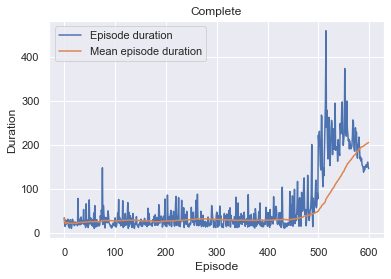

In [38]:
##############################################################
# Training loop
##############################################################
episode_durations = []
for n_epi in range(600):
    prev_log_prob = None
    done = False
    s = env.reset()

    t = 0
    while not done:  # CartPole-v1 forced to terminates at 500 step.
        prob = model.policy(tensor_f(s))
        dist = Categorical(prob)
        a = dist.sample()

        next_state, r, done, info = env.step(a.item())
        log_prob = dist.log_prob(a)

        if prev_log_prob:
            advantage = r + (1 - done) * gamma * model.value(tensor_f(next_state)) - model.value(tensor_f(s))
            critic_loss = advantage.pow(2).mean()

            advantage_detach = advantage.detach()
            ratio = (log_prob - prev_log_prob.detach()).exp()
            clipped = torch.clamp(ratio, 1 - eps, 1 + eps) * advantage_detach
            policy_loss = -torch.min(ratio * advantage_detach, clipped)

            loss = policy_loss + critic_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        s = next_state
        t += 1
        prev_log_prob = log_prob

    episode_durations.append(t + 1)
    if n_epi < 1 or n_epi % 20 == 0:
        PlotDurations.train_plot(episode_durations)

env.close()
PlotDurations.complete_plot(episode_durations)

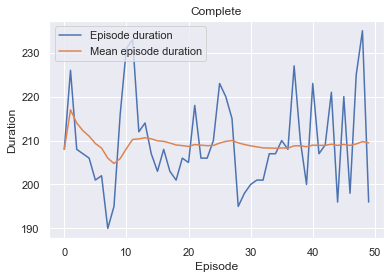

In [5]:
##############################################################
# Testing loop
##############################################################
episode_durations = []
model.eval()
for i_episode in range(50):
    s = env.reset()
    done = False

    t = 0
    while not done:
        prob = model.policy(torch.tensor(s, device=device, dtype=torch.float))
        a = Categorical(prob).sample()
        s_prime, r, done, info = env.step(a.item())
        s = s_prime
        t += 1

    episode_durations.append(t + 1)
    if i_episode < 1 or i_episode % 5 == 0:
        PlotDurations.train_plot(episode_durations)

env.close()
PlotDurations.complete_plot(episode_durations)